In [1]:
import os
import pandas as pd
from collections import Counter
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
import evaluate
from torch.utils.tensorboard import SummaryWriter

In [2]:
import sys
print(f"{sys.version}")

3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 15:57:01) [Clang 17.0.6 ]


In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [4]:
# Check for MPS (Metal Performance Shaders) availability
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS for GPU
    print("Using Apple GPU (MPS backend).")
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("Using CPU.")

Using Apple GPU (MPS backend).


In [5]:
os.getcwd()

'/Users/sarwar'

In [6]:
path = "/Users/sarwar/Documents/protein_class"
os.chdir(path) # change dir
os.getcwd()

'/Users/sarwar/Documents/protein_class'

In [7]:
# https://www.kaggle.com/drewbryant/starter-pfam-seed-random-split

# data is randomly splitted in three folders [train(80%), test(10%), dev(10%)]
# reading and concatinating data for each folder.

def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(path, partition)):
    with open(os.path.join(path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)

In [8]:
# data is randomly splitted in three folders [train(80%), test(10%), dev(10%)]
# reading and concatinating data for each folder.

# reading all data_partitions
df_train = read_data('data/random_split/train')
df_val = read_data('data/random_split/dev')
df_test = read_data('data/random_split/test')

df_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,Penicillinase_R,Q81U16_BACAN/8-123,PF03965.16,ISEAELEIMKVLWLKSP.QTANEIIEE.LEDP.MDW..KPKTIRTL...,ISEAELEIMKVLWLKSPQTANEIIEELEDPMDWKPKTIRTLINRLV...
1,Rtt106,POB3_CANAL/362-454,PF08512.12,AGVPCSVKA...SEGYLFPL......DRCFLF.VTKPTLYIPYSE....,AGVPCSVKASEGYLFPLDRCFLFVTKPTLYIPYSEISSVVMSRTGG...
2,F-actin_cap_A,Q8I3I2_PLAF7/12-301,PF01267.17,IRHVLMNSPPGKLYDLVK..DINILL.G.........SSVSIQ.KI...,IRHVLMNSPPGKLYDLVKDINILLGSSVSIQKILEEVLKDYNEKNY...
3,HupF_HypC,O28902_ARCFU/1-65,PF01455.18,MCIAIPGR...I.ER..IDY...............P....IAIVDF...,MCIAIPGRIERIDYPIAIVDFKGLKKEVRIDLLENPQIGDYVLVHV...
4,DUF3794,R6BY75_9CLOT/189-271,PF12673.7,NIFHI..LWEDVDL..E.GVTFKPMG...E...........S.......,NIFHILWEDVDLEGVTFKPMGESISVQGDIHIFVLYEGEGENTPIR...


In [9]:
df_train.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    3637
LRR_1              1927
Acetyltransf_7     1761
His_kinase         1537
Bac_transf         1528
Lum_binding        1504
DNA_binding_1      1345
Chromate_transp    1265
Lipase_GDSL_2      1252
DnaJ_CXXCXGXG      1210
SRP54_N            1185
WD40               1173
OTCace_N           1171
PEP-utilizers      1147
Glycos_trans_3N    1138
THF_DHG_CYH        1113
Prenyltransf       1104
HTH_1              1064
Maf                1061
DHH                1057
dtype: int64

In [10]:
df_val.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
THF_DHG_CYH        138
Prenyltransf       138
HTH_1              133
Maf                132
DHH                131
dtype: int64

In [11]:
# Print the size of each dataset
print(f"Training dataset size: {df_train.shape[0]} rows")
print(f"Validation dataset size: {df_val.shape[0]} rows")
print(f"Test dataset size: {df_test.shape[0]} rows")

Training dataset size: 1086741 rows
Validation dataset size: 126171 rows
Test dataset size: 126171 rows


/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/3094684390.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['seq_char_count'].values)
/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/3094684390.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['seq_cha

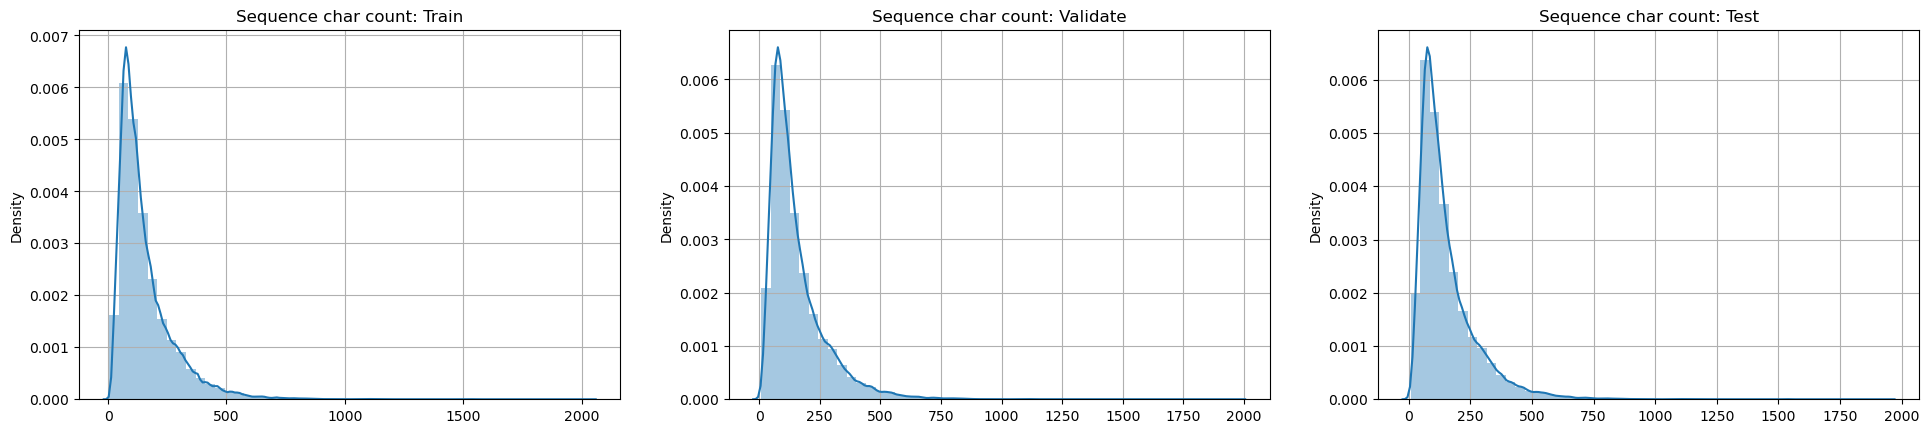

In [12]:
# Length of sequence in train data.
df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))

def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Validate')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

Codes: Train
Total unique codes: 25
Codes: Val
Total unique codes: 22
Codes: Test
Total unique codes: 24


/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/3063473852.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Code', y='Freq', data=data, ax=ax, palette='tab10')
/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/3063473852.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Code', y='Freq', data=data, ax=ax, palette='tab10')
/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/3063473852.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Code', y='Freq', data=data, ax=ax, palette='tab

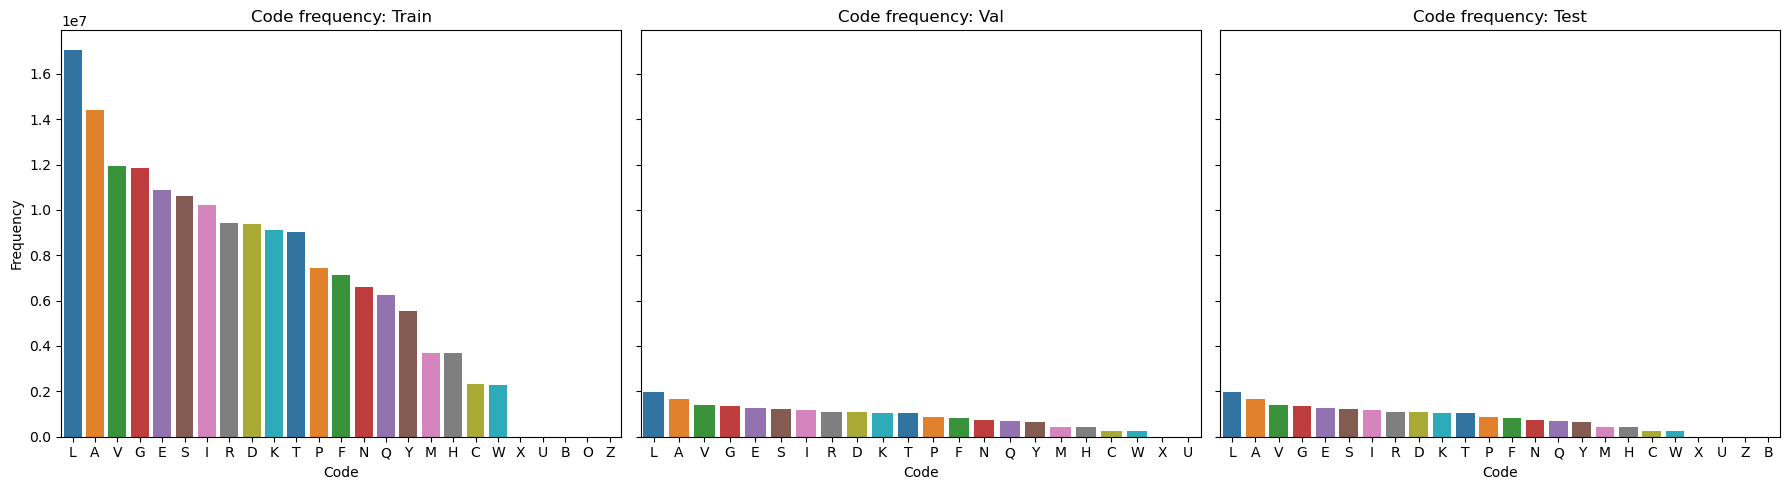

In [13]:
def get_code_freq(df, data_name):
    """Calculates frequency of each code and returns a sorted DataFrame."""
    df = df.apply(lambda x: " ".join(x))  # Concatenate sequences with spaces

    codes = []
    for i in df:  # Concatenate all codes
        codes.extend(i)

    codes_dict = Counter(codes)  # Get frequency count
    codes_dict.pop(' ', None)  # Remove white space if present

    print(f'Codes: {data_name}')
    print(f'Total unique codes: {len(codes_dict.keys())}')

    df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
    return df.sort_values('Freq', ascending=False).reset_index(drop=True)

def plot_code_frequency(train, val, test):
    """Plots the frequency of amino acid codes for train, val, and test datasets."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for ax, data, title in zip(axes, [train, val, test], ['Train', 'Val', 'Test']):
        ax.grid(axis='y', visible=False)  # Turn off horizontal grid lines
        ax.grid(axis='x', visible=False)  # Keep vertical grid lines
        sns.barplot(x='Code', y='Freq', data=data, ax=ax, palette='tab10')
        ax.set_title(f'Code frequency: {title}')
        ax.set_xlabel('Code')
        ax.set_ylabel('Frequency')
        

    plt.tight_layout()
    plt.show()

# Assuming df_train, df_val, and df_test contain the 'sequence' column
train_code_freq = get_code_freq(df_train['sequence'], 'Train')
val_code_freq = get_code_freq(df_val['sequence'], 'Val')
test_code_freq = get_code_freq(df_test['sequence'], 'Test')

# Plot the frequencies
plot_code_frequency(train_code_freq, val_code_freq, test_code_freq)

### Subset Analysis (top 20 classes)

In [14]:
unique_family_ids = df_train['family_id'].nunique()
# Print the result
print(f"Number of unique family_id values: {unique_family_ids}")

Number of unique family_id values: 17929


In [15]:
unique_family_ids = df_val['family_id'].nunique()

# Print the result
print(f"Number of unique family_id values: {unique_family_ids}")

Number of unique family_id values: 13071


In [16]:
uique_family_ids = df_test['family_id'].nunique()

# Print the result
print(f"Number of unique family_id values: {unique_family_ids}")

Number of unique family_id values: 13071


In [17]:
def select_family_subset(df_train, df_val, df_test, selected_families):
    """
    Selects and returns a subset of the dataset containing only the specified families.
    """
    # Filter datasets to include only the selected families
    df_train_subset = df_train[df_train['family_id'].isin(selected_families)]
    df_val_subset = df_val[df_val['family_id'].isin(selected_families)]
    df_test_subset = df_test[df_test['family_id'].isin(selected_families)]

    return df_train_subset, df_val_subset, df_test_subset

# List of selected 10 families
#selected_families = ['LRR_1', 'Acetyltransf_7', 'His_kinase', 'Bac_transf',
  #  'Lum_binding', 'DNA_binding_1', 'Chromate_transp',
   # 'Lipase_GDSL_2', 'DnaJ_CXXCXGXG', 'SRP54_N']

## top 20 families, selected.

selected_families = ['Methyltransf_25', 'LRR_1', 'Acetyltransf_7', 'His_kinase', 'Bac_transf', 'Lum_binding', 
       'DNA_binding_1', 'Chromate_transp', 'Lipase_GDSL_2', 'DnaJ_CXXCXGXG', 'SRP54_N', 
       'OTCace_N', 'WD40', 'PEP-utilizers', 'Glycos_trans_3N', 'THF_DHG_CYH', 'Prenyltransf', 
       'HTH_1', 'Maf', 'DHH']


# Select the subset of data for further analysis
df_train_subset, df_val_subset, df_test_subset = select_family_subset(df_train, df_val, df_test, selected_families)

# Now df_train_subset, df_val_subset, and df_test_subset can be used for further analysis


In [18]:
# To check the number of rows in df_train_subset
print(df_train_subset.shape[0])
df_train_subset.head()

28179


,family_id,sequence_name,family_accession,aligned_sequence,sequence,seq_char_count
71,HTH_1,Q9F2K8_STRCO/4-63,PF00126.27,VRHLECFVAVAEES.HFGRAAT.RLGM...AQPPLSQRIQRLEK.E...,VRHLECFVAVAEESHFGRAATRLGMAQPPLSQRIQRLEKELGVRLF...,60
99,Methyltransf_25,Q2S1D8_SALRD/44-141,PF13649.6,ILDIGCGR.G...R..HA...RA..LV.RR.......G...........,ILDIGCGRGRHARALVRRGWQVTGLDLSEDAVAAARSRVADDDLDV...,98
138,Chromate_transp,R6I3V0_9PROT/2-178,PF02417.15,FELLISFLQIGAFSIGGGYATL.PLIQEQI........VE.........,FELLISFLQIGAFSIGGGYATLPLIQEQIVELHQWLTYKEFTDIIT...,177
193,HTH_1,Q2K7G0_RHIEC/4-59,PF00126.27,.RQLKTFLAVIRHG.NLTRAAA.EVNL...AQSSLSDQIQALEE.E...,RQLKTFLAVIRHGNLTRAAAEVNLAQSSLSDQIQALEEELGAELFV...,56
211,SRP54_N,E5S7X2_TRISP/6-83,PF02881.19,LGRKIRNAI.GSLSHAT.I...I....NEEV.LTSMLKEVCTALLE...,LGRKIRNAIGSLSHATIINEEVLTSMLKEVCTALLEADVNIRLVKQ...,78


In [19]:
# To check the number of rows in df_train_subset
print(df_val_subset.shape[0])
df_val_subset.head()

3511


,family_id,sequence_name,family_accession,aligned_sequence,sequence,seq_char_count
37,DNA_binding_1,R7XUX1_9ACTN/76-156,PF01035.20,AFQQRV.WEQ.LRL..IPYGETASYGEIA................G...,AFQQRVWEQLRLIPYGETASYGEIAGRLGMTNAASRAVGLANGRNP...,81
61,Lipase_GDSL_2,G0RZP4_CHATD/19-209,PF13472.6,CFGDS.LTA.......GYCSM............................,CFGDSLTAGYCSMGAMFHPYHERLEQMLAMAFPDIAFETVEDGVPG...,191
78,Acetyltransf_7,B0CFD8_ACAM1/98-175,PF13508.7,NWS.R..FQ...................V................I...,NWSRFQVIEQAGTLAGCALLNAYSSHSELAYVFVQSQFRHQGWGSQ...,78
91,HTH_1,Q87XZ5_PSESM/5-64,PF00126.27,LRQLQVFVAVARQE.SVSKAAV.LLSL...SQSAASTSITELER.Q...,LRQLQVFVAVARQESVSKAAVLLSLSQSAASTSITELERQSSCQLF...,60
155,DNA_binding_1,A7T264_NEMVE/13-95,PF01035.20,KFCRKV.WKV.VGE.QIKPGQTISYSDVA................K...,KFCRKVWKVVGEQIKPGQTISYSDVAKLMGNPKAARAVGMAMKSNP...,83


In [20]:
# To check the number of rows in df_train_subset
print(df_test_subset.shape[0])
df_test_subset.head()

3511


,family_id,sequence_name,family_accession,aligned_sequence,sequence,seq_char_count
16,Lipase_GDSL_2,H6MZH3_GORPV/43-278,PF13472.6,ALGDS.RAS.......GNMPGLQ......................P...,ALGDSRASGNMPGLQPSDGCWRSSTSYPSVLARIAHVRSFVDRSCA...,236
56,THF_DHG_CYH,S3CNX4_OPHP1/11-126,PF00763.23,.ILADSIGK...N........MLV.EVQ...ESR...............,ILADSIGKNMLVEVQESRDAFRKEHGIERKLCLAAFLANDDPHAVK...,116
116,Bac_transf,G4L597_TETHN/7-186,PF02397.16,KRALGFFL.SL.....IGII.I.L.S...P.I.L...L....I......,KRALGFFLSLIGIIILSPILLIICLAIKIDSKGPIIFKQKRVGKNK...,180
183,His_kinase,J7ISE4_DESMD/359-437,PF06580.13,SE.I..RALQAQIQPHFLFNTLNTV......V....SL...I.......,SEIRALQAQIQPHFLFNTLNTVVSLIRSQPEKAREVLIFLGEFLRR...,79
198,His_kinase,R5EZN7_9CLOT/386-465,PF06580.13,SE.L..KALQAQIQPHFLYNSLDSV......M....WL...L.......,SELKALQAQIQPHFLYNSLDSVMWLLRMDKNRDAEKMLNELSTLFK...,80


/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/1140291937.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='family_id', order=df['family_id'].value_counts().index, ax=ax, palette='tab10')
/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/1140291937.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='family_id', order=df['family_id'].value_counts().index, ax=ax, palette='tab10')
/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/1140291937.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

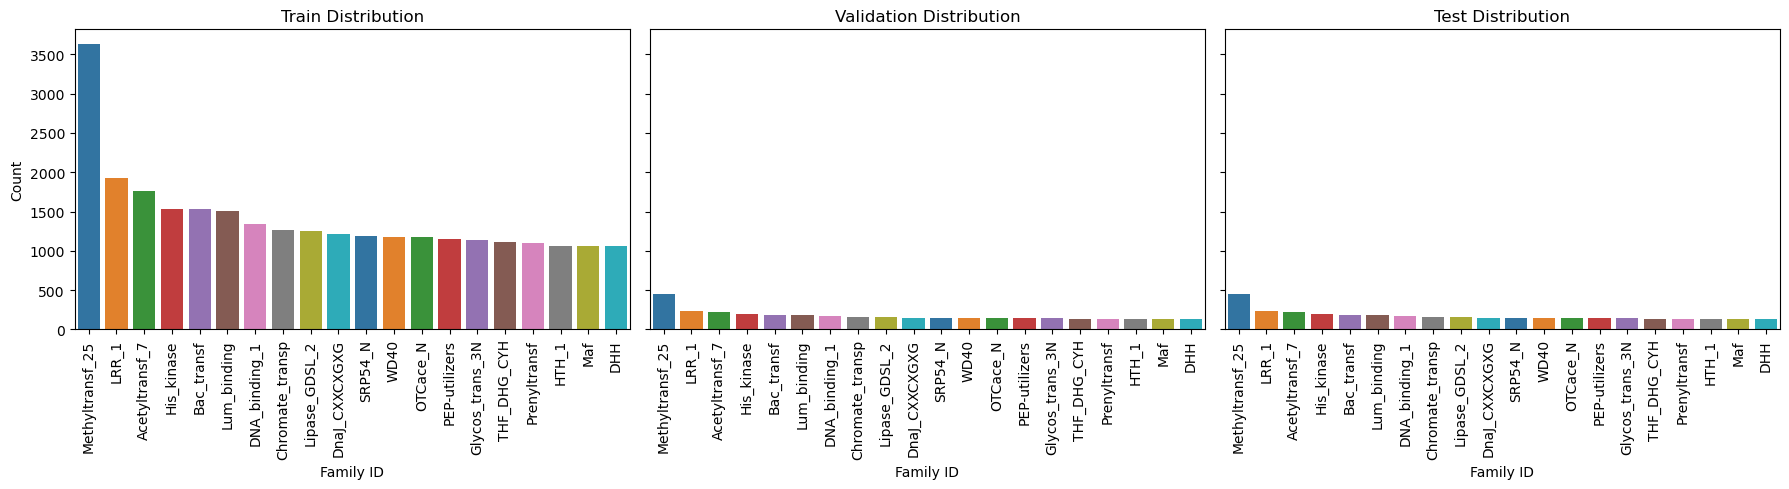

In [21]:
def plot_family_counts(df_train_subset, df_val_subset, df_test_subset):
    """Plots the distribution of family counts for train, val, and test datasets."""
    # Define the datasets and titles
    datasets = [df_train_subset, df_val_subset, df_test_subset]
    titles = ['Train', 'Validation', 'Test']

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for ax, df, title in zip(axes, datasets, titles):
        # Create a count plot for each dataset
        sns.countplot(data=df, x='family_id', order=df['family_id'].value_counts().index, ax=ax, palette='tab10')
        ax.set_title(f'{title} Distribution')
        ax.set_xlabel('Family ID')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Plot the family counts for the training, validation, and test datasets
plot_family_counts(df_train_subset, df_val_subset, df_test_subset)


In [22]:
 class SeqDataset(torch.utils.data.Dataset):
  '''This class is used to create a dataset for the model'''
  def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

  def __len__(self):
      return len(self.labels)

In [23]:
# use subset of dataset
dataset_train = df_train_subset
dataset_dev = df_val_subset
dataset_test = df_test_subset

# ================================================ use all dataset
#dataset_train = df_train
#dataset_dev = df_val
#dataset_test = df_test

class_count_dic = dataset_train['family_id'].value_counts().to_dict() # class count dictionary contains the class name and the number of samples in the class

#classes = list(class_count_dic.keys())[0:10] # select the 10 classes from the dataset

classes = list(class_count_dic.keys()) # select all classes ============================================



In [24]:
class_count_dic

{'Methyltransf_25': 3637,
 'LRR_1': 1927,
 'Acetyltransf_7': 1761,
 'His_kinase': 1537,
 'Bac_transf': 1528,
 'Lum_binding': 1504,
 'DNA_binding_1': 1345,
 'Chromate_transp': 1265,
 'Lipase_GDSL_2': 1252,
 'DnaJ_CXXCXGXG': 1210,
 'SRP54_N': 1185,
 'WD40': 1173,
 'OTCace_N': 1171,
 'PEP-utilizers': 1147,
 'Glycos_trans_3N': 1138,
 'THF_DHG_CYH': 1113,
 'Prenyltransf': 1104,
 'HTH_1': 1064,
 'Maf': 1061,
 'DHH': 1057}

In [25]:
len(classes)

20

In [26]:
# here we retrieve the different datasets based on the selected classes
dataset_train_small= dataset_train
dataset_dev_small= dataset_dev
dataset_test_small= dataset_test

/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/4051084494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_train_small['seq_char_count']= dataset_train_small['sequence'].apply(lambda x: len(x))
/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/4051084494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_dev_small['seq_char_count']= dataset_dev_small['sequence'].apply(lambda x: len(x))
/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/40510

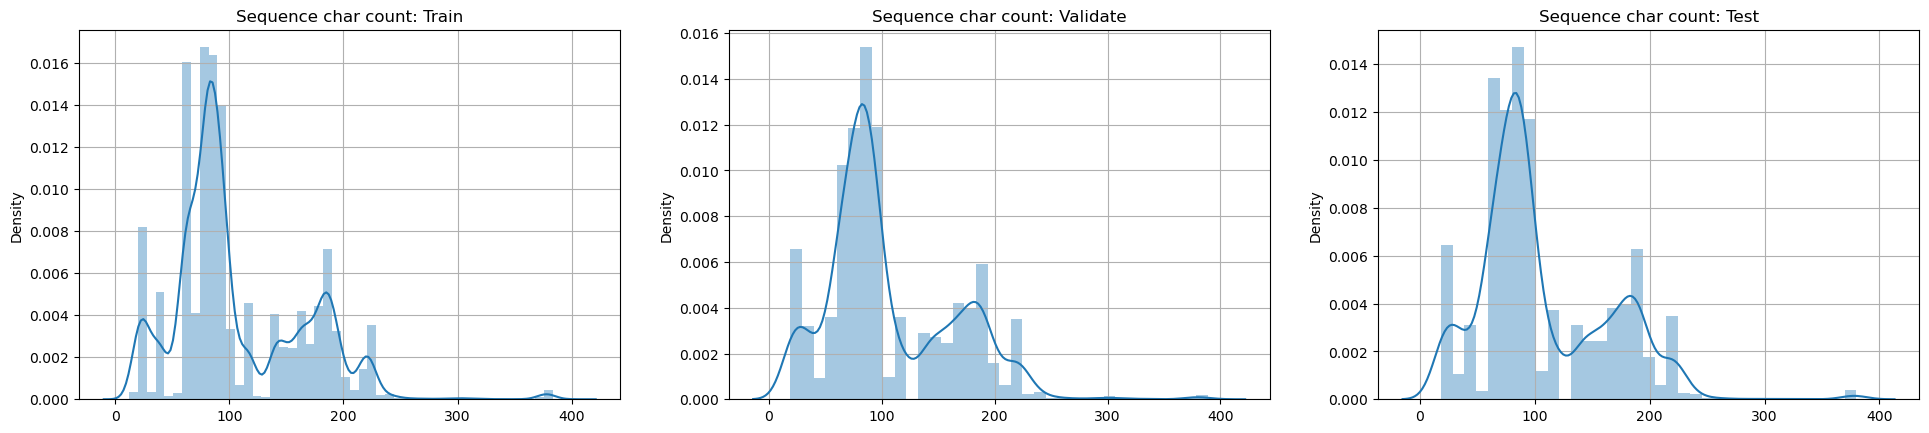

In [27]:
# Length of sequences of subset data.
dataset_train_small['seq_char_count']= dataset_train_small['sequence'].apply(lambda x: len(x))
dataset_dev_small['seq_char_count']= dataset_dev_small['sequence'].apply(lambda x: len(x))
dataset_test_small['seq_char_count']= dataset_test_small['sequence'].apply(lambda x: len(x))

def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

plt.subplot(1, 3, 1)
plot_seq_count(dataset_train_small, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(dataset_dev_small, 'Validate')

plt.subplot(1, 3, 3)
plot_seq_count(dataset_test_small, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [28]:
# calculate the length of the sequences in the train set
sequence_len_df = dataset_train_small['sequence'].apply(len)
max_len = int(np.median(np.quantile(sequence_len_df, 0.99))) # we set max_len to be the percentile 99th so we don't have to zero-pad all sequences to be length of a sequence that the longest 


In [29]:
max_len

238

In [30]:
print(dataset_train_small.seq_char_count.quantile(0.99))
dataset_train_small.seq_char_count.describe()

238.0


count    28179.000000
mean       106.633876
std         57.400055
min         12.000000
25%         68.500000
50%         87.000000
75%        151.000000
max        399.000000
Name: seq_char_count, dtype: float64

In [31]:
# For dataset_train_small
dataset_train_small = dataset_train_small[dataset_train_small['seq_char_count'] <= 238]

# For dataset_dev_small
dataset_dev_small = dataset_dev_small[dataset_dev_small['seq_char_count'] <= 238]

# For dataset_test_small
dataset_test_small = dataset_test_small[dataset_test_small['seq_char_count'] <= 238]

/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/4051084494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_train_small['seq_char_count']= dataset_train_small['sequence'].apply(lambda x: len(x))
/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/4051084494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_dev_small['seq_char_count']= dataset_dev_small['sequence'].apply(lambda x: len(x))
/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/40510

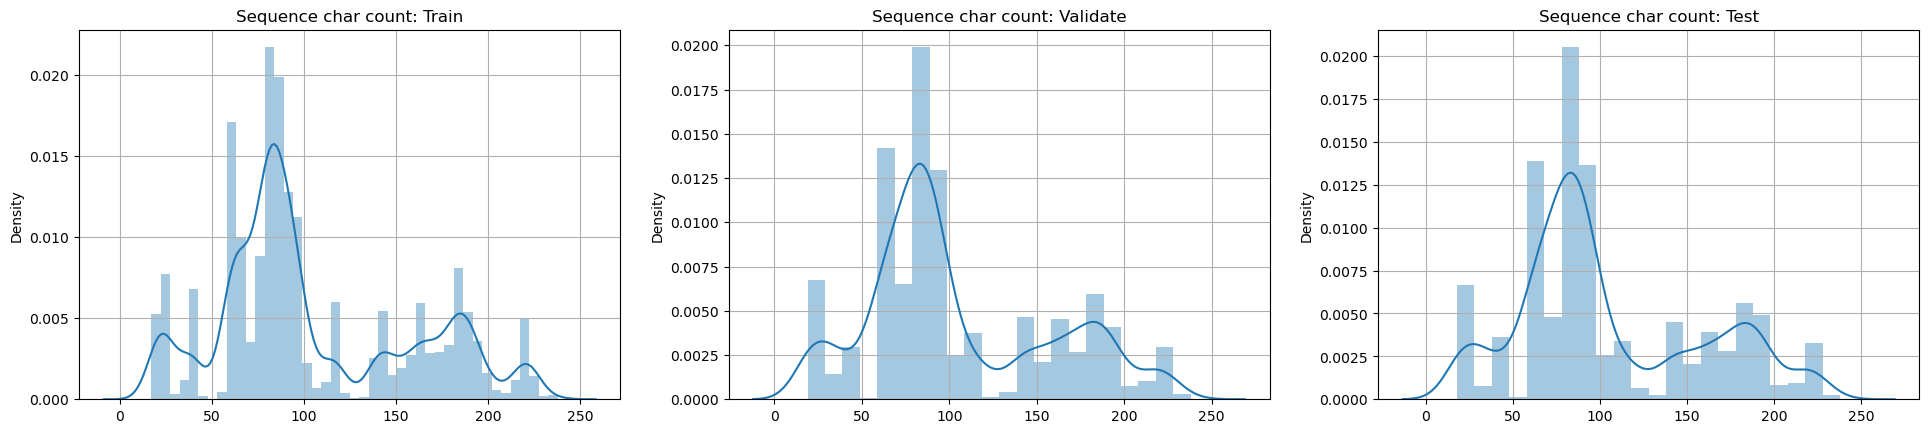

In [32]:
# Length of sequences of subset data.
dataset_train_small['seq_char_count']= dataset_train_small['sequence'].apply(lambda x: len(x))
dataset_dev_small['seq_char_count']= dataset_dev_small['sequence'].apply(lambda x: len(x))
dataset_test_small['seq_char_count']= dataset_test_small['sequence'].apply(lambda x: len(x))

def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

plt.subplot(1, 3, 1)
plot_seq_count(dataset_train_small, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(dataset_dev_small, 'Validate')

plt.subplot(1, 3, 3)
plot_seq_count(dataset_test_small, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [33]:
# label encoding for converting classes to integers
le = LabelEncoder()
y_train_int = le.fit_transform(dataset_train_small['family_id'])
y_dev_int = le.transform(dataset_dev_small['family_id'])
y_test_int = le.transform(dataset_test_small['family_id'])

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D", do_lower_case=False, model_max_length= max_len) # ==== max_len

#tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D", do_lower_case=False, model_max_length= max_len)

train_encodings = tokenizer(dataset_train_small['sequence'].to_list(), truncation=True, padding=True, return_tensors="pt")

dev_encodings = tokenizer(dataset_dev_small['sequence'].to_list(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(dataset_test_small['sequence'].to_list(), truncation=True, padding=True, return_tensors="pt")

train_dataset = SeqDataset(train_encodings, y_train_int)
dev_dataset = SeqDataset(dev_encodings, y_dev_int)
test_dataset = SeqDataset(test_encodings, y_test_int)


In [34]:
# Save the fitted LabelEncoder for later use
#import joblib
#joblib.dump(le, "label_encoder_class20.pkl")  # Save the fitted encoder to a file

### Create ouput directories

In [35]:
#!pip install transformers[torch]

In [36]:
# remove previous log, if any
#!rm -rf ./results_8M_c20_tmp/training_logs
#!rm -rf ./results_8M_c20_tmp/training_results

In [37]:
# Create directories if not already present
output_dir = './results_8M_c20_tmp/training_results'
logging_dir = './results_8M_c20_tmp/training_logs'

os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

In [38]:
#import datetime
#log_folder = "results_35M/training_logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

### Setting Model's Hyperparameters

In [39]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

from transformers import EarlyStoppingCallback, TrainerCallback

model = AutoModelForSequenceClassification.from_pretrained("facebook/esm2_t6_8M_UR50D", num_labels= len(classes))

#model = AutoModelForSequenceClassification.from_pretrained("facebook/esm2_t12_35M_UR50D", num_labels= len(classes))

eps = 10
bs = 16
steps = len(train_dataset) // bs 

metric = evaluate.load('accuracy')

def compute_acc(eval_pred):
    '''This function is used to compute the accuracy of the model'''
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Training arguments
training_args = TrainingArguments(
    output_dir=output_dir,            # Output directory for checkpoints
    num_train_epochs=eps,             # Number of training epochs
    per_device_train_batch_size=bs,   # Batch size for training
    per_device_eval_batch_size=bs,    # Batch size for evaluation
    warmup_steps=500,                 # Warmup steps for learning rate scheduler
    weight_decay=0.01,                # Weight decay
    logging_dir=logging_dir,          # Directory for logs
    logging_steps=steps,              # Steps interval for logging
    logging_strategy="steps",         # Log at regular intervals
    load_best_model_at_end=True,      # Load the best model at the end of training
    metric_for_best_model="eval_loss", # Save the best model or use "accuracy"
    evaluation_strategy='epoch',      # Evaluate at the end of every epoch
    save_strategy='epoch',            # Save checkpoints at the end of every epoch
    learning_rate=1e-4                # learning rate
)

# Early stoping
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,  # Stop training if no improvement after 3 evaluations
    early_stopping_threshold=0.001  # Minimum improvement required to consider it as better
)

trainer = Trainer(
    model=model,                                        # the instantiated Transformers model to be trained
    args=training_args,                                 # training arguments, defined above
    train_dataset=train_dataset,                        # training dataset
    eval_dataset=dev_dataset,                           # evaluation dataset
    compute_metrics = compute_acc,                      
    tokenizer=tokenizer,
    callbacks=[early_stopping]  # Adding EarlyStoppingCallback
    )

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/envs/md-intro-tutorial/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/2884318514.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [40]:
# train function starts the training
#trainer.train()

In [41]:
#!pip install wandb -qU

In [42]:
import wandb

# ... login ...

wandb.login(key="15c5a4c7787aee681bea83a5b9f995855e551b84")

# Before trainer.train()
wandb.init(project="HPC_project", name="8M_c20_Mac_tmp") # Initialize wandb with your project name

# train function starts the training
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sarwarisu24 (sarwarisu24-iowa-state-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/sarwar/.netrc


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/1956749121.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy
1,0.456900,0.006042,0.999425
2,0.001900,0.000874,1.000000
3,0.000400,0.000265,1.000000
4,0.000200,0.000109,1.000000
5,0.000100,0.000048,1.000000


/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/1956749121.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/1956749121.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/1956749121.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {

TrainOutput(global_step=8725, training_loss=0.09184741290402933, metrics={'train_runtime': 2339.4557, 'train_samples_per_second': 119.293, 'train_steps_per_second': 7.459, 'total_flos': 1495999954762320.0, 'train_loss': 0.09184741290402933, 'epoch': 5.0})

In [ ]:

# ... (after training) ...
#wandb.finish() # Close the wandb run

In [43]:
df = pd.DataFrame(trainer.state.log_history)
# Extract metrics
training_loss = df['loss'].dropna().tolist()
validation_loss = df['eval_loss'].dropna().tolist()
validation_accuracy = df['eval_accuracy'].dropna().tolist()

# Extract epochs (from even-numbered rows only)
epochs = df.loc[(df.index + 1) % 2 == 0, 'epoch'].dropna().unique().astype(int)

# Ensure data alignment for plotting
aligned_training_loss = training_loss[:len(epochs)]
aligned_validation_loss = validation_loss[:len(epochs)]
aligned_validation_accuracy = validation_accuracy[:len(epochs)]

### Plot Loss vs Epochs

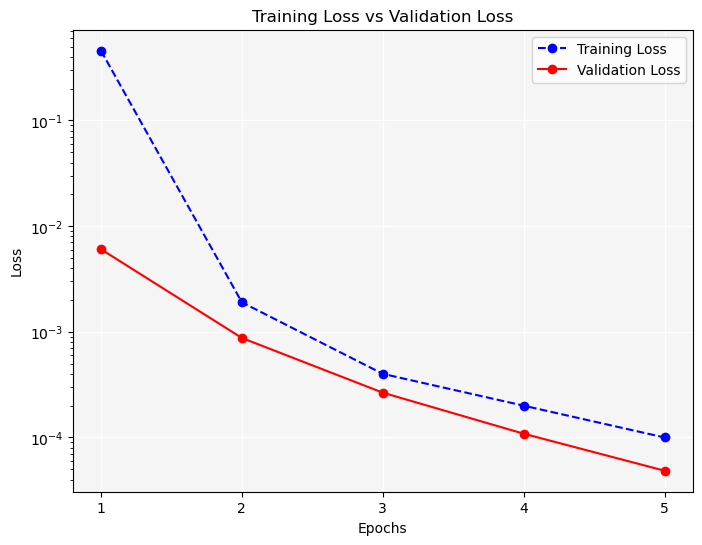

In [44]:
# Replace zeros with a small positive value
training_loss = [max(loss, 1e-6) for loss in aligned_training_loss]
validation_loss = [max(loss, 1e-6) for loss in aligned_validation_loss]

# Plotting
plt.figure(figsize=(8, 6))

# Plot data
plt.plot(epochs, training_loss, label="Training Loss", color="blue", marker='o', linestyle='--')
plt.plot(epochs, validation_loss, label="Validation Loss", color="red", marker='o', linestyle='-')

# Customize plot
plt.title("Training Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()

# Use logarithmic scale for y-axis
plt.yscale('log')

# Add white vertical and horizontal lines
plt.grid(color='white', linestyle='-', linewidth=1)

# Set the grid's background
plt.gca().set_facecolor('whitesmoke')  # Optional for a light gray background

plt.show()


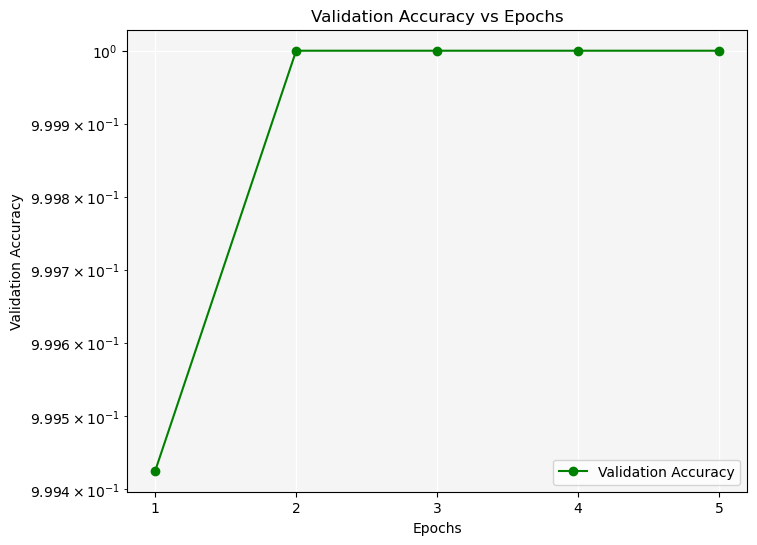

In [45]:
# Replace zeros with a small positive value
validation_accuracy = [max(acc, 1e-6) for acc in aligned_validation_accuracy]

# Plotting
plt.figure(figsize=(8, 6))

# Plot data
plt.plot(epochs, validation_accuracy, label="Validation Accuracy", color="green", marker='o', linestyle='-')

# Customize plot
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.xticks(epochs)
plt.legend()

# Use logarithmic scale for y-axis
plt.yscale('log')

# Add white vertical and horizontal lines
plt.grid(color='white', linestyle='-', linewidth=1)

# Set the grid's background
plt.gca().set_facecolor('whitesmoke')  # Optional for a light gray background

plt.show()


In [ ]:
# Define TensorBoard writer
#writer = SummaryWriter('./results_8M/training_logs')


# Custom Training Loop with Logging
#for epoch in range(training_args.num_train_epochs):
    # Call `trainer.train()` once for all epochs
#    if epoch == 0:
#        trainer.train()
    
    # Optionally log custom metrics
#    train_loss = trainer.state.log_history[-1].get('loss', None)  # Last logged train loss
#    val_loss = trainer.evaluate()['eval_loss']  # Last logged eval loss

#    writer.add_scalar('Loss/train', train_loss, epoch)
#    writer.add_scalar('Loss/validation', val_loss, epoch)

# Close the TensorBoard writer when done
#writer.close()

### Testing the trained model

In [46]:
# evaluate function evaluates the model on the input dataset
#wandb.login(key="15c5a4c7787aee681bea83a5b9f995855e551b84")

# Before trainer.train()
#wandb.init(project="HPC_project", name="8M_c20_Mac", settings=wandb.Settings(init_timeout=300)) # Initialize wandb with your project name

#wandb.init(project="HPC_project", name="8M_c20_Mac", mode="offline")

trainer.evaluate(test_dataset)

# ... (after testing) ...
print("Finishing wandb...")
#wandb.finish() # Close the wandb run
print("wandb finished.")

/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/1956749121.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Finishing wandb...
wandb finished.


### Visualize Confusion Matrix

/var/folders/t6/ckdl967100l58lcs0vnyrbf58sk9pd/T/ipykernel_11418/1956749121.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


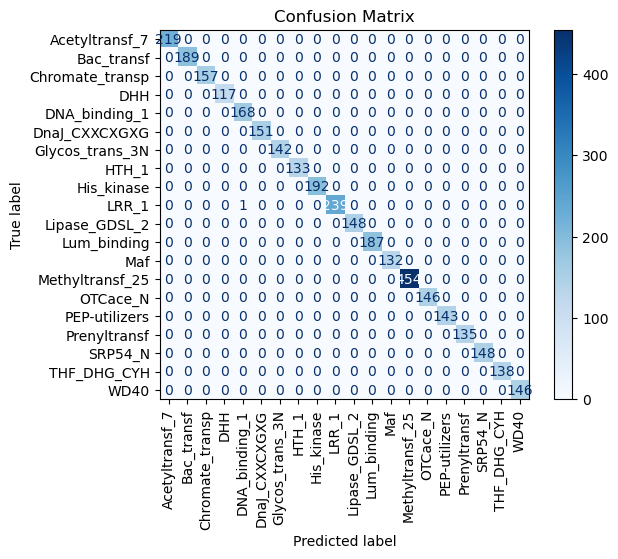

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for the test dataset
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()


### Classification Report

In [48]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=le.classes_)
print(report)


                 precision    recall  f1-score   support

 Acetyltransf_7       1.00      1.00      1.00       219
     Bac_transf       1.00      1.00      1.00       189
Chromate_transp       1.00      1.00      1.00       157
            DHH       1.00      1.00      1.00       117
  DNA_binding_1       0.99      1.00      1.00       168
  DnaJ_CXXCXGXG       1.00      1.00      1.00       151
Glycos_trans_3N       1.00      1.00      1.00       142
          HTH_1       1.00      1.00      1.00       133
     His_kinase       1.00      1.00      1.00       192
          LRR_1       1.00      1.00      1.00       240
  Lipase_GDSL_2       1.00      1.00      1.00       148
    Lum_binding       1.00      1.00      1.00       187
            Maf       1.00      1.00      1.00       132
Methyltransf_25       1.00      1.00      1.00       454
       OTCace_N       1.00      1.00      1.00       146
  PEP-utilizers       1.00      1.00      1.00       143
   Prenyltransf       1.00    